In [1]:
from utils import setup_seed, AverageMeter
from tqdm import tqdm
from foolbox import PyTorchModel
from foolbox.attacks import LinfPGD
from sigmoid_method import exp
from datasets import load_cifar10
from models.resnet import resnet50
import torch.nn as nn
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import numpy as np
model = resnet50("cifar10")
setup_seed(3407)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
train_dataloader, test_dataloader, data_min, data_max = load_cifar10()


Files already downloaded and verified
Files already downloaded and verified


In [3]:
class FGSM:
    def __init__(self, epsilon, data_min, data_max):
        self.epsilon = epsilon
        self.criterion = nn.CrossEntropyLoss()
        self.data_min = data_min
        self.data_max = data_max

    def __call__(self, model, data, target, num_steps=50, alpha=0.001):
        dt = data.clone().detach().requires_grad_(True)
        for _ in range(num_steps):
            output = model(dt)
            if output.argmax() != target:
                break
            loss = self.criterion(output, target)
            loss.backward()
            dt.data = dt.data + alpha * dt.grad.data.sign()
            dt.data = torch.clamp(dt.data, self.data_min, self.data_max)
            dt.grad.data.zero_()
        return dt, output.argmax() != target
    

In [4]:
fgsm = FGSM(epsilon=0.001, data_min=data_min, data_max=data_max)

In [5]:
def plot_picture(model,data, dt, delta_x):
    fig, axes = plt.subplots(1, 3)
    axes[0].bar(range(10), F.softmax(
        model(data), dim=1).squeeze().detach().cpu().numpy())
    axes[0].set_title("Original")
    axes[0].set_xticks(range(10))
    axes[1].bar(range(10), F.softmax(
        model(dt), dim=1).squeeze().detach().cpu().numpy())
    axes[1].set_title("Adversarial")
    axes[1].set_xticks(range(10))
    print(model(data+delta_x).argmax(-1))
    axes[2].bar(range(10), F.softmax(model(data+delta_x),
                dim=1).squeeze().detach().cpu().numpy())
    axes[2].set_title("modified")
    axes[2].set_xticks(range(10))
    plt.show()


tensor([5], device='cuda:0')
tensor(5.0842, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.0918, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.2856, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1904, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.1897, device='cuda:0', grad_fn=<AddBackward0>)
tensor([5], device='cuda:0')


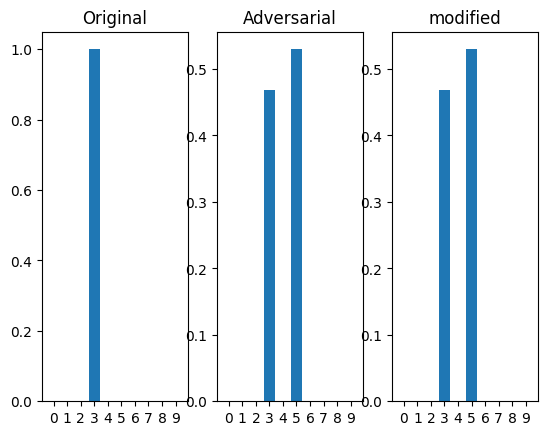

tensor(6.3240e-05, device='cuda:0', grad_fn=<DivBackward0>)


In [8]:
for x, label in test_dataloader:
    x, label = x.to(device), label.to(device)
    pred = model(x)
    correct = pred.argmax(-1) == label
    x = x[correct]
    label = label[correct]
    for i in range(10):
        adv_data, success = fgsm(model,x[i:i+1],target=label[i:i+1])
        if not success:
            continue
        delta_x = adv_data - x[i:i+1]
        y = model(adv_data)
        print(y.argmax(-1))
        norm, delta = exp(model, x[i:i+1].squeeze(), delta_x.squeeze(), y.squeeze(), steps=5, alpha=0.01, lbda=0.01, kind=1)
        plot_picture(model,x[i:i+1],(x[i:i+1]+delta_x),delta)
        b = norm - torch.norm(delta_x)
        a = norm
        val = b / (-(a-b))
        print(val)
        break
    break